# Example 5a - Beachface Cluster Dynamics indices - transect level

<img src="images/banner3.png" width="100%" />

<font face="Calibri">
<br>
<font size="5"> <b>Transect scale beachface behavioural modelling</b></font>

<br>
<font size="4"> <b> Nicolas Pucino; PhD Student @ Deakin University, Australia </b> <br>
<img style="padding:7px;" src="images/sandpiper_sand_retouched.png" width="170" align="right" /></font>

<font size="3">These indices represents the tendency of the location, or transect, to either erode or accrete, based on the temporal succession of sand-only change.<br>

<b>This notebook covers the following concepts:</b>

- Modelling r-BCDs at the transect scale.
- Plotting.
- Sensitivity analysis.
</font>


</font>

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import itertools
from tqdm.notebook import tqdm


from sandpyper.outils import getLoc, getDate,coords_to_points
from sandpyper.dynamics import  steady_state_transect, compute_rBCD_transects, infer_weights

crs_dict_string={"mar":{'init': 'epsg:32754'},
         "leo":{'init': 'epsg:32755'}}

C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


This time, as previously specified, we use the __full dh dataset__, not the hotspot filtered one.

In [22]:
in_file=r"C:\my_packages\doc_data\profiles\markov_tagged_fulldh_df.csv"
dirNameTrans=r"C:\my_packages\doc_data\transects\\"

dataset=pd.read_csv(in_file)

dataset["coordinates"]=dataset.geometry.apply(coords_to_points)
dataset_gdf=gpd.GeoDataFrame(dataset, geometry="coordinates",crs=crs_dict_string['mar'])
dataset_gdf.sort_values(['date_pre'], inplace=True)

C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Let's use only Marengo data, which has a longer timeseries compared to St. Leonards.

In [250]:
dataset_mar=dataset.query("location=='mar'")
dataset_mar

,Unnamed: 0,geometry,location,tr_id,distance,dt,date_pre,date_post,z_pre,z_post,dh,jc_bin,markov_tag,coordinates
2725,4733,POINT (731579.306667006 5705473.42672466),mar,20,30.4,dt_7,2019-03-13,2019-05-16,1.392407,1.127059,-0.265348,3,se,POINT (731579.307 5705473.427)
2726,4734,POINT (731579.221439936 5705473.47903476),mar,20,30.5,dt_7,2019-03-13,2019-05-16,1.414008,1.135922,-0.278085,3,se,POINT (731579.221 5705473.479)
2727,4735,POINT (731579.1362128661 5705473.53134486),mar,20,30.6,dt_7,2019-03-13,2019-05-16,1.427494,1.147608,-0.279886,3,se,POINT (731579.136 5705473.531)
2728,4742,POINT (731556.3417177059 5705441.53390942),mar,18,36.5,dt_7,2019-03-13,2019-05-16,1.774062,1.608972,-0.165090,3,se,POINT (731556.342 5705441.534)
2729,4743,POINT (731555.141984757 5705442.03454986),mar,18,37.8,dt_7,2019-03-13,2019-05-16,1.847479,1.734514,-0.112966,4,ue,POINT (731555.142 5705442.035)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31087,31087,POINT (731468.0187435427 5705156.375496609),mar,3,44.7,dt_0,2018-06-01,2018-06-21,2.075071,2.708724,0.633653,3,hd,POINT (731468.019 5705156.375)
31088,31088,POINT (731467.8198957373 5705156.396933733),mar,3,44.9,dt_0,2018-06-01,2018-06-21,2.090222,2.918043,0.827821,3,hd,POINT (731467.820 5705156.397)
31089,31089,POINT (731467.7204718346 5705156.407652295),mar,3,45.0,dt_0,2018-06-01,2018-06-21,2.116984,3.143203,1.026220,3,hd,POINT (731467.720 5705156.408)
31090,31090,POINT (731467.621047932 5705156.418370857),mar,3,45.1,dt_0,2018-06-01,2018-06-21,2.140646,3.303227,1.162581,3,hd,POINT (731467.621 5705156.418)


As no transitions are represented, there is no need to use weights. However, the use of weights can be implemented with passing the weights dictionary.

In [258]:
# Weights are all ones, which means no weights.

weights_dict={"ee":1,"ed":1,
        "he":1,"hd":1,
        "me":1,"md":1,
        "se":1,"sd":1,
        "ue":1,"ud":1}

label_order=['ed', 'hd', 'md', 'sd', 'ud', 'ue', 'se', 'me', 'he', 'ee']

two parameters are important:
* min_points: the minimum required valid points per transect to consider a transect reliable.
* thresh: the minimum number of timesteps required to retain a transect.


In [256]:
thresh=7
min_points=20

ss_tr=steady_state_transect(dataset_mar,
                            field_unique_id='geometry',
                            min_points=min_points,
                            thresh=thresh,
                            mode='nnn',
                            unreal="drop"
                           )
ss_tr

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 5 not reached. It has 0 points.
tr_id 5 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 0 points.
tr_id 4 has not enough points. Go ahead...
Threshold of points per transect 3 not reached. It has 0 points.
tr_id 3 has not enough points. Go ahead...
eliminating unreliable transects . . . 


,markov_tag,tr_id,p,location,thresh,min_pts,valid_pts
0,ed,7,0.019709,mar,7,20,68
1,ee,7,0.025622,mar,7,20,68
2,hd,7,0.013796,mar,7,20,68
3,he,7,0.007884,mar,7,20,68
4,md,7,0.073959,mar,7,20,68
...,...,...,...,...,...,...,...
154,nnn,20,0.140533,mar,7,20,31
155,sd,20,0.082767,mar,7,20,31
156,se,20,0.011735,mar,7,20,31
157,ud,20,0.179821,mar,7,20,31


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!


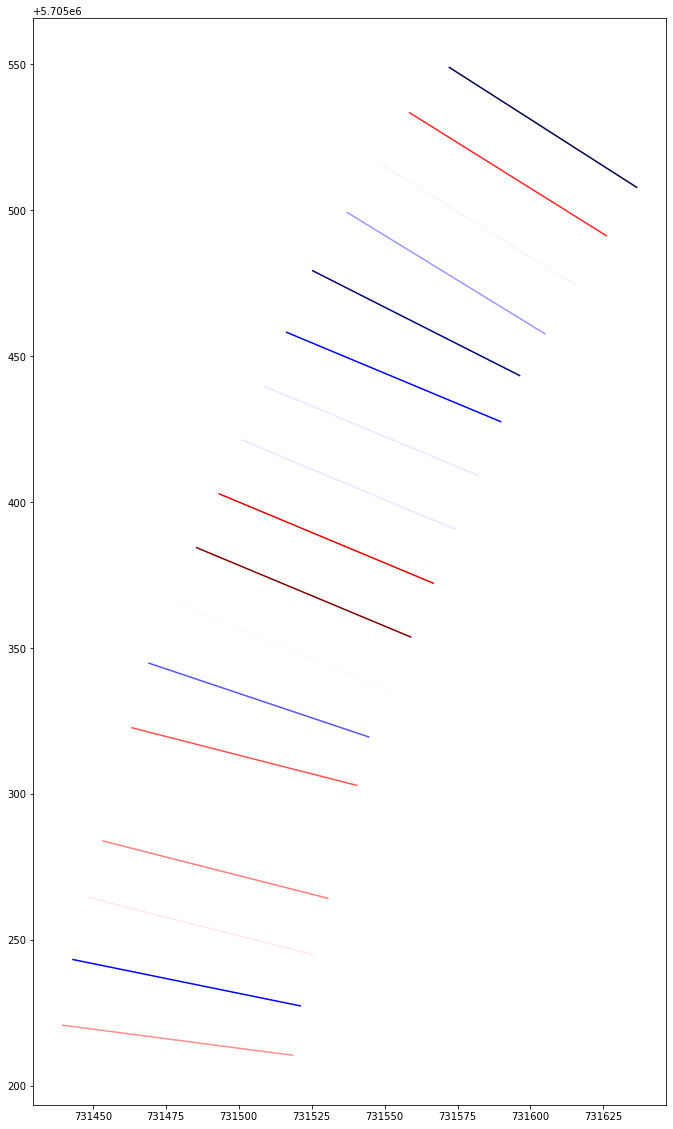

In [257]:
f,ax= plt.subplots(figsize=(20,20))

ss_transects_idx,idx_table=compute_rBCD_transects(dirNameTrans=dirNameTrans,label_order=label_order,
                                                steady_state_tr=ss_tr,weights_dict=weights_dict,
                                                loc='mar')

ss_transects_idx.plot(column='residual', ax=ax, cmap='seismic_r');

In [240]:
n_trans=dataset_mar.groupby(['tr_id'])["dt"].unique().reset_index()
n_trans['n_dt']=[n_trans.iloc[i,-1].shape[0] for i in np.arange(n_trans.shape[0]) ]

ss_transects_idx=pd.merge(ss_transects_idx,n_trans[["tr_id","n_dt"]], on=['tr_id'], how='left')
ss_transects_idx

,location,tr_id,deposition,erosion,residual,geometry,n_dt
0,mar,3,0.562746,0.437254,0.125493,"MULTILINESTRING ((731512.461 5705151.584, 7314...",6
1,mar,4,0.393864,0.606136,-0.212272,"MULTILINESTRING ((731514.605 5705171.469, 7314...",6
2,mar,5,0.469637,0.530363,-0.060726,"MULTILINESTRING ((731516.749 5705191.354, 7314...",6
3,mar,6,0.443974,0.324034,0.119940,"MULTILINESTRING ((731518.785 5705210.340, 7314...",8
4,mar,7,0.638576,0.297066,0.341510,"MULTILINESTRING ((731521.351 5705227.262, 7314...",7
5,mar,8,0.519564,0.266492,0.253072,"MULTILINESTRING ((731525.857 5705244.754, 7314...",8
6,mar,9,0.448012,0.354373,0.093639,"MULTILINESTRING ((731530.795 5705264.135, 7314...",8
7,mar,10,0.510952,0.298933,0.212020,"MULTILINESTRING ((731535.734 5705283.516, 7314...",8
8,mar,11,0.451879,0.315312,0.136566,"MULTILINESTRING ((731540.659 5705302.846, 7314...",8
9,mar,12,0.543623,0.309869,0.233753,"MULTILINESTRING ((731544.821 5705319.413, 7314...",8


## Sensitivity analysis

For a reliable computation of r-BCDs at the transect scale the Δh points within the subaerial beachface must be beyond the period-specific LoDs.

This filtering process assures that only high quality data is used in the r-BCDs computation to the detriment of the total number of valid observations per transect. Moreover, two additional filtering steps are applied at the site-level, to ensure that are only retained:
* points that remain valid for at least a certain amount of Δh periods (t)
* transects that have a number of valid points greater than a determined minimum threshold (pt)

This is done to ensure comparability across time and transects in a determined location.
Therefore, __t is an important parameter that should ideally be as high as the available time periods__, in order to ensure that the maximum behavioural variability is captured.<br>
Yet, setting this parameter very high can reduce considerably the number of valid points retained in a single transect, which in turn can fall below t, leading to the loss of transects from the final behavioural map.<br>
It is also informative to monitor and try to minimise the number of transects that __passed from a depositional to erosional behavioral regime (or vice versa) in the last time period (i. e. changed sign from t-1 to t),__ for any chosen t. Those transects could signal a behaviour that only emerged by choosing a determined value for t, signaling a potentially __lower confidence in their r-BCD values__.<br>
For these reasons, the sensitivity analysis helps in choosing a __sub-optimal combination of t and p such as__:
* at least 85% (arbitrary) of the total transects are retained
* a reasonably low number of sign changes occurred

We start by defining all the combinations between the parameters __thresh (t)__ and __min_pts (pt)__, given ranges that we define.<br>
The thresh parameter can be up to the total number of timesteps available, while the min_pts, we decide to test the values from 0 to 210, with a step of 10.

In [261]:
range_thresh=range(0,dataset.dt.unique().shape[0]+1)
range_min_pts=range(0,210,10)
combs = list(itertools.product(range_min_pts,range_thresh))

And, we run the analysis.

In [262]:
%%time

ss_tr_big=pd.DataFrame()

for i in tqdm(combs):
    print(f"Working on threshold {i[1]} and min points {i[0]}.")
    try:
        ss_tr=steady_state_transect(dataset_mar,
                     field_unique_id='geometry',
                     thresh=i[1], min_points=i[0], unreal="drop" )
        if ss_tr.shape[0] > 0:
            ss_transects_idx,to_plot=compute_rBCD_transects(dirNameTrans=dirNameTrans,label_order=label_order,
                                                        steady_state_tr=ss_tr,
                                                        loc='mar',weights_dict=weights_dict)
            ss_transects_idx['thresh']=i[1]
            ss_transects_idx['min_pts']=i[0]

            ss_tr_big=pd.concat([ss_tr_big,ss_transects_idx], ignore_index=True)

        else:
            pass
    except:
        print(f"Skipping")
    
ss_tr_big

<timed exec>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/189 [00:00<?, ?it/s]

Working on threshold 0 and min points 0.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 0.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 0.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 0.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 0.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 0.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 0.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 0.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has not enough points. Go ahead...
tr_id 5 has not enough points. Go ahead...
tr_id 4 has not enough points. Go ahead...
tr_id 3 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 8 and min points 0.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 18 has not enough points. Go ahead...
tr_id 13 has not enough points. Go ahead...
tr_id 12 has not enough points. Go ahead...
tr_id 10 has not enough points. Go ahead...
tr_id 9 has not enough points. Go ahead...
tr_id 6 has not enough points. Go ahead...
tr_id 24 has not enough points. Go ahead...
tr_id 23 has not enough points. Go ahead...
tr_id 22 has not enough points. Go ahead...
tr_id 21 has not enough points. Go ahead...
tr_id 7 has not enough points. Go ahead...
tr_id 5 has not enough points. Go ahead...
tr_id 4 has not enough points. Go ahead...
tr_id 3 has not enough points. Go ahead...
eliminating unreliable transects . . . 
Skipping
Working on threshold 0 and min points 10.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 10.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 10.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 10.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 10.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 10.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching mar ...
 Done!
Working on threshold 6 and min points 10.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 10.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 5 not reached. It has 0 points.
tr_id 5 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 0 points.
tr_id 4 has not enough points. Go ahead...
Threshold of points per transect 3 not reached. It has 0 points.
tr_id 3 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 8 and min points 10.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 20.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 20.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 20.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching mar ...
 Done!
Working on threshold 4 and min points 20.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 20.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 20.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 20.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 5 not reached. It has 0 points.
tr_id 5 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 0 points.
tr_id 4 has not enough points. Go ahead...
Threshold of points per transect 3 not reached. It has 0 points.
tr_id 3 has not enough points. Go ahead...
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 8 and min points 20.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 30.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 30.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 30.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching mar ...
 Done!
Working on threshold 4 and min points 30.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 30.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 30.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 30.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 21 not reached. It has 27 points.
Threshold of points per transect 5 not reached. It has 0 points.
tr_id 5 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 0 points.
tr_id 4 has not enough points. Go ahead...
Threshold of points per transect 3 not reached. It has 0 points.
tr_id 3 has not enough points. Go ahead...
eliminating unreliable transects . . . 
 Attaching False ...


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 8 and min points 30.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 40.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 40.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 40.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 40.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 40.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 40.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 40.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 21 not reached. It has 27 points.
Threshold of points per transect 5 not reached. It has 0 points.
tr_id 5 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 0 points.
tr_id 4 has not enough points. Go ahead...
Threshold of points per transect 3 not reached. It has 0 points.
tr_id 3

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 8 and min points 40.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 50.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 50.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 50.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 50.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching mar ...
 Done!
Working on threshold 5 and min points 50.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 50.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 44 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 50.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 22 not reached. It has 45 points.
Threshold of points per transect 21 not reached. It has 27 points.
Threshold of points per transect 5 not reached. It has 0 points.
tr_id 5 has not enough p

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 8 and min points 50.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 60.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 60.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 60.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 60.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 60.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 60.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 44 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 60.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 23 not reached. It has 52 points.
Threshold of points pe

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 8 and min points 60.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 70.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 70.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 70.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 70.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 70.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 70.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 44 points.
Threshold of points per transect 3 not reached. It has 60 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 70.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 23 not reached. It has 52 points.
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 80.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 80.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 80.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching mar ...
 Done!
Working on threshold 4 and min points 80.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 80.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 80.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 44 points.
Threshold of points per transect 3 not reached. It has 60 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 80.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching mar ...
 Done!
Working on threshold 1 and min points 90.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 90.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 90.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 90.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 90.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 90.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 44 points.
Threshold of points per transect 3 not reached. It has 60 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 90.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 100.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 100.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 100.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 100.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 100.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 100.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 18 not reached. It has 93 points.
Threshold of points per transect 10 not reached. It has 97 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 22 not reached. It has 96 points.
Threshold of points per transect 21 not reached. It has 98 points.
Threshold of points per transect 5 not reached. It has 90 points.
Threshold of points per transect 4 not reached. It has 44 points.
Threshold of points per transect 3 not reached. It has 60 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 100.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 110.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 110.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 110.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 110.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching mar ...
 Done!
Working on threshold 5 and min points 110.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 110.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 18 not reached. It has 93 points.
Threshold of points per transect 11 not reached. It has 100 points.
Threshold of points per transect 10 not reached. It has 97 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 22 not reached. It has 96 points.
Threshold of points per transect 21 not reached. It has 98 points.
Threshold of points per transect 5 not reached. It has 90 points.
Threshold of points per transect 4 not reached. It has 44 points.
Threshold of points per transect 3 not reached. It has 60 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 110.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 120.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 120.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 120.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 120.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching mar ...
 Done!
Working on threshold 5 and min points 120.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
Threshold of points per transect 21 not reached. It has 116 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 120.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 18 not reached. It has 93 points.
Threshold of points per transect 16 not reached. It has 116 points.
Threshold of points per transect 14 not reached. It has 114 points.
Threshold of points per transect 13 not reached. It has 110 points.
Threshold of points per transect 12 not reached. It has 114 points.
Threshold of points per transect 11 not reached. It has 100 points.
Threshold of points per transect 10 not reached. It has 97 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 23 not reached. It has 114 points.
Threshold of points per transect 22 not reached. It has 96 points.
Threshold of points per transect 21 not reached. It has 98 points.
Threshold of points per transect 5 not reached. It has 90 points.
Threshold of points per transect 4 not reached. It has 44 points.
Threshold of points per transect 3 not reached. It has 60 points.
eliminating unre

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 120.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 130.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 130.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 130.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 130.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 130.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
Threshold of points per transect 22 not reached. It has 124 points.
Threshold of points per transect 21 not reached. It has 116 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 130.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 18 not reached. It has 93 points.
Threshold of points per transect 17 not reached. It has 128 points.
Threshold of points per transect 16 not reached. It has 116 points.
Threshold of points per transect 14 not reached. It has 114 points.
Threshold of points per transect 13 not reached. It has 110 points.
Threshold of points per transect 12 not reached. It has 114 points.
Threshold of points per transect 11 not reached. It has 100 points.
Threshold of points per transect 10 not reached. It has 97 points.
Threshold of points per transect 9 not reached. It has 121 points.
Threshold of points per transect 8 not reached. It has 126 points.
Threshold of points per transect 6 not reached. It has 126 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 23 not reached. It has 114 points.
Threshold of points per transect 22 not reached. It has 96 points.
Threshold of

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 7 and min points 130.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 140.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 140.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 140.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 140.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
Threshold of points per transect 21 not reached. It has 134 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 140.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 12 not reached. It has 139 points.
Threshold of points per transect 11 not reached. It has 134 points.
Threshold of points per transect 10 not reached. It has 136 points.
Threshold of points per transect 24 not reached. It has 3 points.
Threshold of points per transect 22 not reached. It has 124 points.
Threshold of points per transect 21 not reached. It has 116 points.
eliminating unreliable transects . . . 
 Attaching False ...

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 140.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 130 points.
Threshold of points per transect 18 not reached. It has 93 points.
Threshold of points per transect 17 not reached. It has 128 points.
Threshold of points per transect 16 not reached. It has 116 points.
Threshold of points per transect 15 not reached. It has 134 points.
Threshold of points per transect 14 not reached. It has 114 points.
Threshold of points per transect 13 not reached. It has 110 points.
Threshold of points per transect 12 not reached. It has 114 points.
Threshold of points per transect 11 not reached. It has 100 points.
Threshold of points per transect 10 not reached. It has 97 points.
Threshold of points per transect 9 not reached. It has 121 points.
Threshold of points per transect 8 not reached. It has 126 points.
Threshold of points per transect 6 not reached. It has 126 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold o

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 150.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 150.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 150.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching mar ...
 Done!
Working on threshold 4 and min points 150.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
Threshold of points per transect 22 not reached. It has 144 points.
Threshold of points per transect 21 not reached. It has 134 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 150.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 12 not reached. It has 139 points.
Threshold of points per transect 11 not reached. It has 134 points.
Threshold of points per transect 10 not reached. It has 136 points.
Threshold of points per transect 24 not reached. It has 3 points.
Threshold of points per transect 22 not reached. It has 124 points.
Threshold of points per transect 21 not reached. It has 116 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 150.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 130 points.
Threshold of points per transect 18 not reached. It has 93 points.
Threshold of points per transect 17 not reached. It has 128 points.
Threshold of points per transect 16 not reached. It has 116 points.
Threshold of points per transect 15 not reached. It has 134 points.
Threshold of points per transect 14 not reached. It has 114 points.
Threshold of points per transect 13 not reached. It has 110 points.
Threshold of points per transect 12 not reached. It has 114 points.
Threshold of points per transect 11 not reached. It has 100 points.
Threshold of points per transect 10 not reached. It has 97 points.
Threshold of points per transect 9 not reached. It has 121 points.
Threshold of points per transect 8 not reached. It has 126 points.
Threshold of points per transect 6 not reached. It has 126 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold o

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 160.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 160.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 160.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
Threshold of points per transect 21 not reached. It has 151 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 160.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
Threshold of points per transect 22 not reached. It has 144 points.
Threshold of points per transect 21 not reached. It has 134 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 160.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 18 not reached. It has 153 points.
Threshold of points per transect 14 not reached. It has 152 points.
Threshold of points per transect 12 not reached. It has 139 points.
Threshold of points per transect 11 not reached. It has 134 points.
Threshold of points per transect 10 not reached. It has 136 points.
Threshold of points per transect 24 not reached. It has 3 points.
Threshold of points per transect 23 not reached. It has 151 points.
Threshold of points per transect 22 not reached. It has 124 points.
Threshold of points per transect 21 not reached. It has 116 points.
Threshold of points per transect 19 not reached. It has 153 points.
Threshold of points per transect 4 not reached. It has 156 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 160.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 130 points.
Threshold of points per transect 18 not reached. It has 93 points.
Threshold of points per transect 17 not reached. It has 128 points.
Threshold of points per transect 16 not reached. It has 116 points.
Threshold of points per transect 15 not reached. It has 134 points.
Threshold of points per transect 14 not reached. It has 114 points.
Threshold of points per transect 13 not reached. It has 110 points.
Threshold of points per transect 12 not reached. It has 114 points.
Threshold of points per transect 11 not reached. It has 100 points.
Threshold of points per transect 10 not reached. It has 97 points.
Threshold of points per transect 9 not reached. It has 121 points.
Threshold of points per transect 8 not reached. It has 126 points.
Threshold of points per transect 6 not reached. It has 126 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold o

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 170.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 170.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 170.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
Threshold of points per transect 21 not reached. It has 151 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 170.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 12 not reached. It has 161 points.
Threshold of points per transect 24 not reached. It has 20 points.
Threshold of points per transect 22 not reached. It has 144 points.
Threshold of points per transect 21 not reached. It has 134 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 170.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 163 points.
Threshold of points per transect 18 not reached. It has 153 points.
Threshold of points per transect 14 not reached. It has 152 points.
Threshold of points per transect 13 not reached. It has 163 points.
Threshold of points per transect 12 not reached. It has 139 points.
Threshold of points per transect 11 not reached. It has 134 points.
Threshold of points per transect 10 not reached. It has 136 points.
Threshold of points per transect 9 not reached. It has 162 points.
Threshold of points per transect 24 not reached. It has 3 points.
Threshold of points per transect 23 not reached. It has 151 points.
Threshold of points per transect 22 not reached. It has 124 points.
Threshold of points per transect 21 not reached. It has 116 points.
Threshold of points per transect 19 not reached. It has 153 points.
Threshold of points per transect 7 not reached. It has 164 points.
Threshold of points per transect 4 not reached. It h

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 170.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 130 points.
Threshold of points per transect 18 not reached. It has 93 points.
Threshold of points per transect 17 not reached. It has 128 points.
Threshold of points per transect 16 not reached. It has 116 points.
Threshold of points per transect 15 not reached. It has 134 points.
Threshold of points per transect 14 not reached. It has 114 points.
Threshold of points per transect 13 not reached. It has 110 points.
Threshold of points per transect 12 not reached. It has 114 points.
Threshold of points per transect 11 not reached. It has 100 points.
Threshold of points per transect 10 not reached. It has 97 points.
Threshold of points per transect 9 not reached. It has 121 points.
Threshold of points per transect 8 not reached. It has 126 points.
Threshold of points per transect 6 not reached. It has 126 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold o

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 180.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 180.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 180.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
Threshold of points per transect 22 not reached. It has 171 points.
Threshold of points per transect 21 not reached. It has 151 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 180.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 12 not reached. It has 161 points.
Threshold of points per transect 11 not reached. It has 176 points.
Threshold of points per transect 24 not reached. It has 20 points.
Threshold of points per transect 23 not reached. It has 178 points.
Threshold of points per transect 22 not reached. It has 144 points.
Threshold of points per transect 21 not reached. It has 134 points.
Threshold of points per transect 19 not reached. It has 170 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 180.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 163 points.
Threshold of points per transect 18 not reached. It has 153 points.
Threshold of points per transect 16 not reached. It has 171 points.
Threshold of points per transect 14 not reached. It has 152 points.
Threshold of points per transect 13 not reached. It has 163 points.
Threshold of points per transect 12 not reached. It has 139 points.
Threshold of points per transect 11 not reached. It has 134 points.
Threshold of points per transect 10 not reached. It has 136 points.
Threshold of points per transect 9 not reached. It has 162 points.
Threshold of points per transect 8 not reached. It has 171 points.
Threshold of points per transect 24 not reached. It has 3 points.
Threshold of points per transect 23 not reached. It has 151 points.
Threshold of points per transect 22 not reached. It has 124 points.
Threshold of points per transect 21 not reached. It has 116 points.
Threshold of points per transect 19 not reached. It 

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 6 and min points 180.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 130 points.
Threshold of points per transect 18 not reached. It has 93 points.
Threshold of points per transect 17 not reached. It has 128 points.
Threshold of points per transect 16 not reached. It has 116 points.
Threshold of points per transect 15 not reached. It has 134 points.
Threshold of points per transect 14 not reached. It has 114 points.
Threshold of points per transect 13 not reached. It has 110 points.
Threshold of points per transect 12 not reached. It has 114 points.
Threshold of points per transect 11 not reached. It has 100 points.
Threshold of points per transect 10 not reached. It has 97 points.
Threshold of points per transect 9 not reached. It has 121 points.
Threshold of points per transect 8 not reached. It has 126 points.
Threshold of points per transect 6 not reached. It has 126 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold o

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 190.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching mar ...
 Done!
Working on threshold 2 and min points 190.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
Threshold of points per transect 22 not reached. It has 182 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 190.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 11 not reached. It has 189 points.
Threshold of points per transect 24 not reached. It has 39 points.
Threshold of points per transect 22 not reached. It has 171 points.
Threshold of points per transect 21 not reached. It has 151 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 190.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 184 points.
Threshold of points per transect 14 not reached. It has 184 points.
Threshold of points per transect 13 not reached. It has 182 points.
Threshold of points per transect 12 not reached. It has 161 points.
Threshold of points per transect 11 not reached. It has 176 points.
Threshold of points per transect 10 not reached. It has 186 points.
Threshold of points per transect 24 not reached. It has 20 points.
Threshold of points per transect 23 not reached. It has 178 points.
Threshold of points per transect 22 not reached. It has 144 points.
Threshold of points per transect 21 not reached. It has 134 points.
Threshold of points per transect 19 not reached. It has 170 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 190.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 163 points.
Threshold of points per transect 18 not reached. It has 153 points.
Threshold of points per transect 16 not reached. It has 171 points.
Threshold of points per transect 15 not reached. It has 182 points.
Threshold of points per transect 14 not reached. It has 152 points.
Threshold of points per transect 13 not reached. It has 163 points.
Threshold of points per transect 12 not reached. It has 139 points.
Threshold of points per transect 11 not reached. It has 134 points.
Threshold of points per transect 10 not reached. It has 136 points.
Threshold of points per transect 9 not reached. It has 162 points.
Threshold of points per transect 8 not reached. It has 171 points.
Threshold of points per transect 24 not reached. It has 3 points.
Threshold of points per transect 23 not reached. It has 151 points.
Threshold of points per transect 22 not reached. It has 124 points.
Threshold of points per transect 21 not reached. It 

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Done!
 Attaching False ...
 Attaching mar ...
 Done!


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


Working on threshold 6 and min points 190.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 130 points.
Threshold of points per transect 18 not reached. It has 93 points.
Threshold of points per transect 17 not reached. It has 128 points.
Threshold of points per transect 16 not reached. It has 116 points.
Threshold of points per transect 15 not reached. It has 134 points.
Threshold of points per transect 14 not reached. It has 114 points.
Threshold of points per transect 13 not reached. It has 110 points.
Threshold of points per transect 12 not reached. It has 114 points.
Threshold of points per transect 11 not reached. It has 100 points.
Threshold of points per transect 10 not reached. It has 97 points.
Threshold of points per transect 9 not reached. It has 121 points.
Threshold of points per transect 8 not reached. It has 126 points.
Threshold of points per transect 6 not reached. It has 126 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold o

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 1 and min points 200.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 2 and min points 200.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
Threshold of points per transect 22 not reached. It has 182 points.
Threshold of points per transect 21 not reached. It has 190 points.
eliminating unreliable transects . . . 
 Attaching False ...
 Attaching mar ...
 Done!


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 3 and min points 200.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 198 points.
Threshold of points per transect 12 not reached. It has 192 points.
Threshold of points per transect 11 not reached. It has 189 points.
Threshold of points per transect 24 not reached. It has 39 points.
Threshold of points per transect 22 not reached. It has 171 points.
Threshold of points per transect 21 not reached. It has 151 points.
Threshold of points per transect 19 not reached. It has 198 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 4 and min points 200.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 184 points.
Threshold of points per transect 14 not reached. It has 184 points.
Threshold of points per transect 13 not reached. It has 182 points.
Threshold of points per transect 12 not reached. It has 161 points.
Threshold of points per transect 11 not reached. It has 176 points.
Threshold of points per transect 10 not reached. It has 186 points.
Threshold of points per transect 24 not reached. It has 20 points.
Threshold of points per transect 23 not reached. It has 178 points.
Threshold of points per transect 22 not reached. It has 144 points.
Threshold of points per transect 21 not reached. It has 134 points.
Threshold of points per transect 19 not reached. It has 170 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


 Attaching False ...
 Attaching mar ...
 Done!
 Attaching False ...
 Attaching mar ...
 Done!
Working on threshold 5 and min points 200.


<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 163 points.
Threshold of points per transect 18 not reached. It has 153 points.
Threshold of points per transect 17 not reached. It has 197 points.
Threshold of points per transect 16 not reached. It has 171 points.
Threshold of points per transect 15 not reached. It has 182 points.
Threshold of points per transect 14 not reached. It has 152 points.
Threshold of points per transect 13 not reached. It has 163 points.
Threshold of points per transect 12 not reached. It has 139 points.
Threshold of points per transect 11 not reached. It has 134 points.
Threshold of points per transect 10 not reached. It has 136 points.
Threshold of points per transect 9 not reached. It has 162 points.
Threshold of points per transect 8 not reached. It has 171 points.
Threshold of points per transect 24 not reached. It has 3 points.
Threshold of points per transect 23 not reached. It has 151 points.
Threshold of points per transect 22 not reached. It 

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 130 points.
Threshold of points per transect 18 not reached. It has 93 points.
Threshold of points per transect 17 not reached. It has 128 points.
Threshold of points per transect 16 not reached. It has 116 points.
Threshold of points per transect 15 not reached. It has 134 points.
Threshold of points per transect 14 not reached. It has 114 points.
Threshold of points per transect 13 not reached. It has 110 points.
Threshold of points per transect 12 not reached. It has 114 points.
Threshold of points per transect 11 not reached. It has 100 points.
Threshold of points per transect 10 not reached. It has 97 points.
Threshold of points per transect 9 not reached. It has 121 points.
Threshold of points per transect 8 not reached. It has 126 points.
Threshold of points per transect 6 not reached. It has 126 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold o

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

<ipython-input-236-c76ea1616a17>:385: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for loc in tqdm(dataset.location.unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

process,location,tr_id,deposition,erosion,residual,geometry,thresh,min_pts
0,mar,3,0.424080,0.356589,0.067491,"MULTILINESTRING ((731512.461 5705151.584, 7314...",0,0
1,mar,4,0.464567,0.336649,0.127919,"MULTILINESTRING ((731514.605 5705171.469, 7314...",0,0
2,mar,5,0.375602,0.388622,-0.013021,"MULTILINESTRING ((731516.749 5705191.354, 7314...",0,0
3,mar,6,0.296762,0.176257,0.120505,"MULTILINESTRING ((731518.785 5705210.340, 7314...",0,0
4,mar,7,0.460313,0.196794,0.263519,"MULTILINESTRING ((731521.351 5705227.262, 7314...",0,0
...,...,...,...,...,...,...,...,...
2850,mar,9,0.402137,0.281376,0.120761,"MULTILINESTRING ((731530.795 5705264.135, 7314...",4,200
2851,mar,15,0.373944,0.355034,0.018909,"MULTILINESTRING ((731566.920 5705372.105, 7314...",4,200
2852,mar,16,0.460512,0.207404,0.253108,"MULTILINESTRING ((731574.622 5705390.563, 7315...",4,200
2853,mar,17,0.516450,0.193548,0.322902,"MULTILINESTRING ((731582.324 5705409.020, 7315...",4,200


Let's plot the transect r-BCDs in function of the thresh parameter.

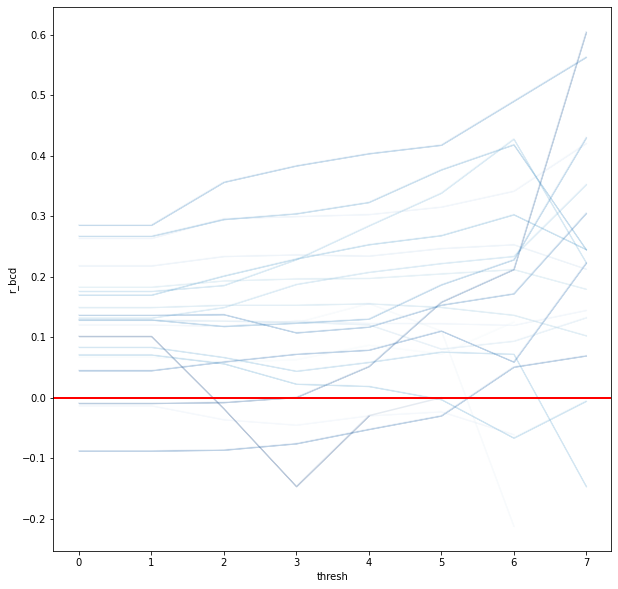

In [263]:
f,ax=plt.subplots(figsize=(10,10))

palette=sb.color_palette("Blues", n_colors=ss_tr_big.tr_id.unique().shape[0])
sb.lineplot(data=ss_tr_big, x='thresh',y='residual', hue='tr_id',
            palette=palette, legend=False, **dict(alpha=0.1),
            ax=ax
)
ax.set_ylabel("r_bcd")
ax.axhline(y=0, lw=2, c='r');

As we can see, there are only 3 transects that flipped their r-BCD sign (depo to ero or viceversa) as a consequence of an increase in the minimum number of timesteps.

In order to better decide a sub-optimal combination of thresh and min_pts that retains the majority of the transects (while keeping an eye on transects that flipped r-BCD), here below we do some plotting.

First, some preprocessing...

In [264]:
trs_res_ar=ss_tr_big.groupby(["tr_id","min_pts"])['residual'].apply(np.array).reset_index()
tot_trs=ss_tr_big.groupby(["thresh","min_pts"])['geometry'].count().reset_index()
tot_trs['trs_10']=tot_trs.geometry / 10
zero_crossings=pd.DataFrame([pd.Series({'tr_id':trs_res_ar.loc[i,'tr_id'],
                                        'sign_change_thresh':np.where(np.diff(np.sign(trs_res_ar.iloc[i,-1])))[0][-1]+1,
                                       'min_pts':trs_res_ar.loc[i,'min_pts']}) for i in range(trs_res_ar.shape[0]) if np.where(np.diff(np.sign(trs_res_ar.iloc[i,-1])))[0].shape[0] !=0])
tot_jumps=zero_crossings.groupby(["sign_change_thresh","min_pts"]).count().reset_index() # how many jumps per thresh and minpts

joined=pd.merge(tot_trs,tot_jumps, left_on=['thresh','min_pts'], right_on=['sign_change_thresh','min_pts'], how='left')
joined.rename({'geometry':'tot_trs',
              'tr_id':'tot_jumps'}, axis=1, inplace=True)
joined

,thresh,min_pts,tot_trs,trs_10,sign_change_thresh,tot_jumps
0,0,0,22,2.2,NaN,NaN
1,0,10,22,2.2,NaN,NaN
2,0,20,22,2.2,NaN,NaN
3,0,30,22,2.2,NaN,NaN
4,0,40,22,2.2,NaN,NaN
...,...,...,...,...,...,...
141,7,20,17,1.7,7.0,1.0
142,7,30,13,1.3,7.0,1.0
143,7,40,9,0.9,7.0,1.0
144,7,50,6,0.6,7.0,1.0


<ipython-input-266-e902b9192c55>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(figsize=(7,4))


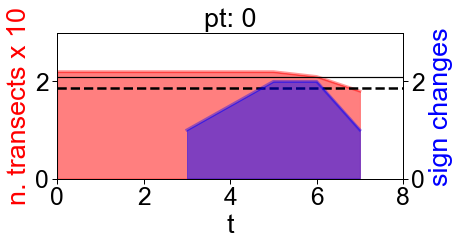

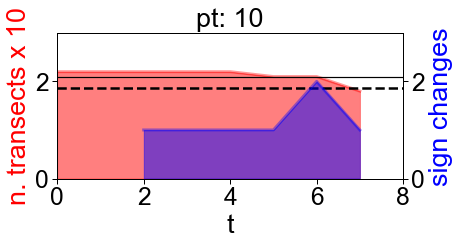

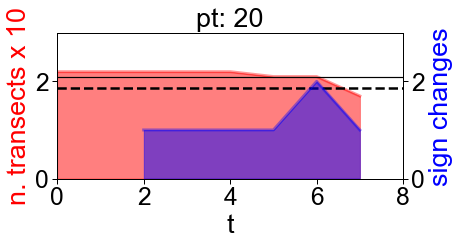

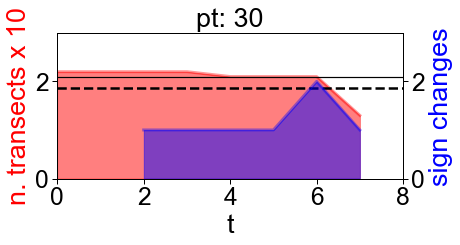

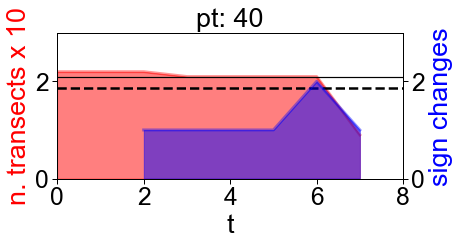

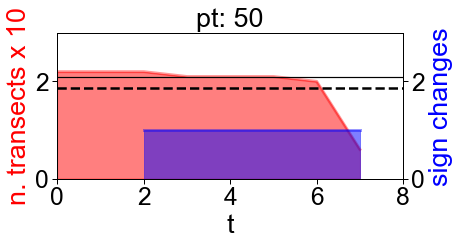

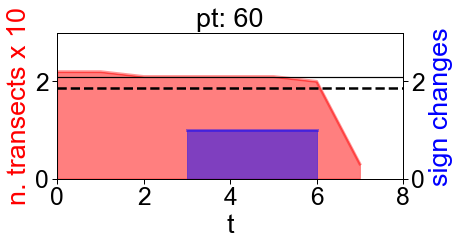

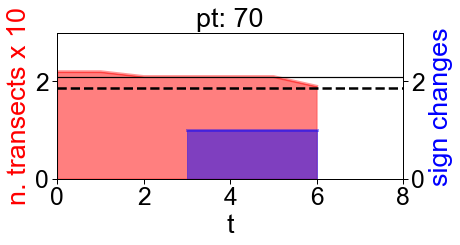

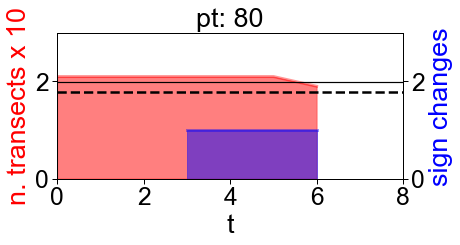

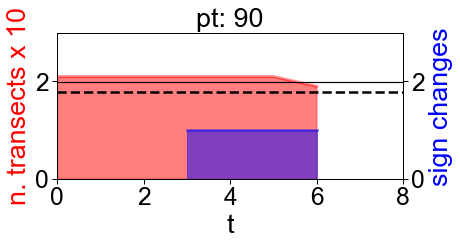

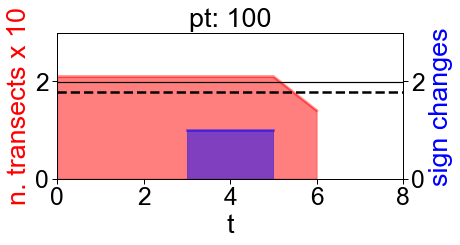

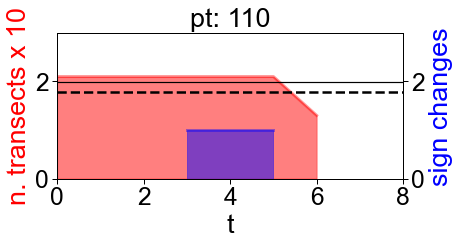

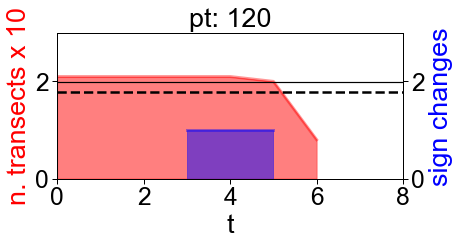

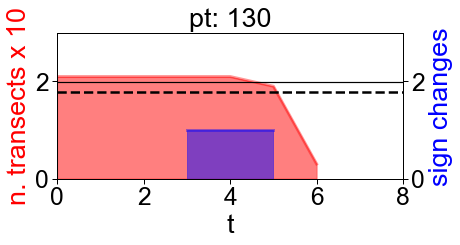

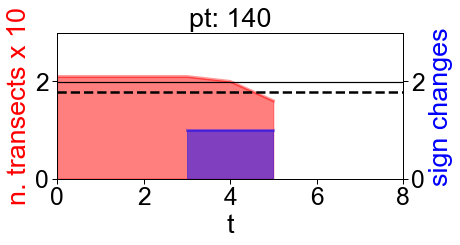

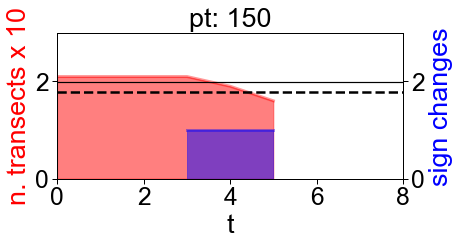

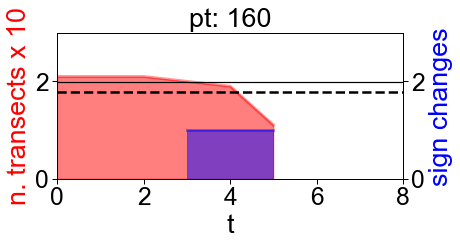

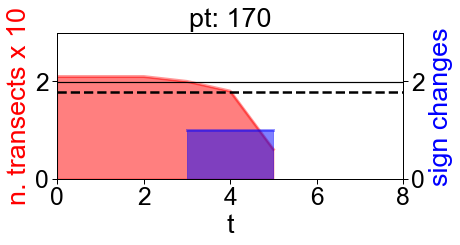

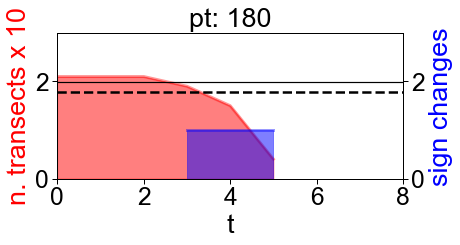

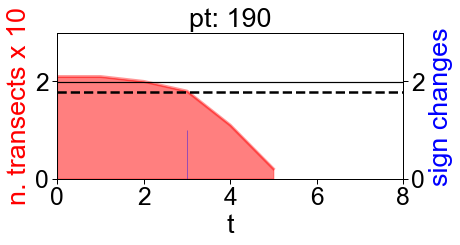

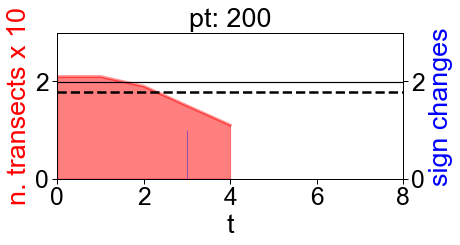

In [266]:
plt.rcParams['font.sans-serif'] = 'Arial'
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = 'sans-serif'
sb.set_context("paper", font_scale=2.8)


x_ticks=[0,2,4,6,8]

q_up_val=0.95
q_low_val=0.85

list_minpts=ss_tr_big.min_pts.unique()

for minpts in list_minpts:

    f,ax=plt.subplots(figsize=(7,4))
    ax2=ax.twinx()
    
    datain=joined.query(f"min_pts=={minpts}")  


    sb.lineplot(x="thresh", y="tot_jumps",ci=None,
                    data=datain,color='b',
                   alpha=.4,linewidth=3,
                ax=ax2, label="sign changes")

    sb.lineplot(data=datain,x='thresh',y='trs_10',
                alpha=.4,color='r',linewidth=3,
                ax=ax,label="transects * 10")
    
    
    kde_x, kde_y = ax.lines[0].get_data()
    kde_x2, kde_y2 = ax2.lines[0].get_data()
    ax.fill_between(kde_x, kde_y,interpolate=True, color='r',alpha=0.5)
    ax2.fill_between(kde_x2, kde_y2,interpolate=True,color='b',alpha=0.5)
    
    ax.axhline((datain.tot_trs.fillna(0).max()*q_up_val)/10,c='k',ls='-',label='95%')
    ax.axhline((datain.tot_trs.fillna(0).max()*q_low_val)/10,c='k',lw=2.5,ls='--',label='85%')
    
    ax.set_ylabel('n. transects x 10', c='r')
    ax.set_xlabel('t')
    ax2.set_ylabel('sign changes', c='b')
    ax2.set_ylim(0,3)
    ax.set_ylim(0,3)
    ax.set_xlim(0,8)
    

    plt.tight_layout()
    ax.get_legend().remove()
    ax2.get_legend().remove()
    
    
    plt.xticks(x_ticks)
    savetxt=f"E:\\path\\to\\save\\revision_0\\location_sensit_minpts_{minpts}.png"
    
    ax.set_title(f"pt: {minpts}")
    plt.tight_layout()
    
#   f.savefig(savetxt, dpi=600); #uncomment to save all images

___